# Generating dataset, preprocessing and forming train-test split

Delta x =  tensor(0.0503)


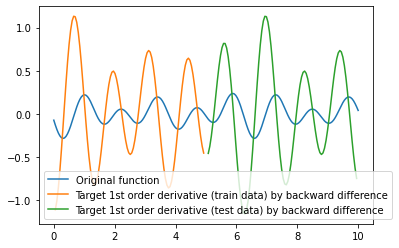

In [1]:
import math
import numpy as np
import torch
import matplotlib.pyplot as plt 
from tqdm import tqdm
import time
import cvxpy as cp
from cvxpylayers.torch import CvxpyLayer
import numpy.random as npr

torch.set_default_tensor_type(torch.DoubleTensor)

t = 0
N = 20
L = 2*math.pi
x = torch.linspace(0,10,200)
f = torch.tensor(0.0)
del_x = x[4]-x[3]
print("Delta x = ",del_x)

np.random.seed(0)
for i in range(1,N+1):
    A = np.random.uniform(low = -0.1, high = 0.1)
    w = np.random.uniform(low = -0.4, high = 0.4)
    phi = np.random.uniform(low = 0.0, high = 2*math.pi)
    l = np.random.choice([2,3,4,5])
    f = f + A*torch.sin(w*t + (2*math.pi*l*x)/L +phi)
    
N = f.size(0)
testPct = 0.5    #train-test split
nTrain = int(N*(1.-testPct))

train_data = f[:nTrain]
test_data = f[nTrain:]

def preprocess(data):
    inputs = torch.DoubleTensor(data.size(0)-2,3)
    outputs = torch.DoubleTensor(data.size(0)-2,1)
    inputs = inputs.cuda()
    outputs = outputs.cuda()
    inputs = torch.autograd.Variable(inputs, requires_grad=True)
    outputs = torch.autograd.Variable(outputs, requires_grad=True)
    for i in range(0, data.size(0)-2):
        inputs.data[i] = torch.DoubleTensor([data[i],data[i+1],data[i+2]])
        outputs.data[i] = (data[i+1]-data[i])/del_x
        
    return inputs,outputs

train_inputs,train_outputs = preprocess(train_data)
test_inputs,test_outputs = preprocess(test_data)
plt.plot(x,f,label = 'Original function')
plt.plot(x[1:99],train_outputs.to('cpu').detach().numpy(),label = 'Target 1st order derivative (train data) by backward difference')
plt.plot(x[-99:-1],test_outputs.to('cpu').detach().numpy(),label = 'Target 1st order derivative (test data) by backward difference')
plt.legend()

# Model Building and Training

In [2]:
class Reconstruct(torch.nn.Module):
    def __init__(self,seed = 0):
        super().__init__()
        torch.manual_seed(seed)
        self.fc1=torch.nn.Linear(3,300)
        self.fc2=torch.nn.Linear(300,3)
        self.D = torch.DoubleTensor([[1,1,1],[del_x,0,((-1)*del_x)]]).to("cuda")
        self.beta = torch.DoubleTensor([0,-1]).to("cuda")
        z = cp.Variable(3)
        D = cp.Parameter((2,3))
        beta = cp.Parameter(2)
        x = cp.Parameter(3)
        objective = (cp.sum_squares(z - x))     #L2 norm square used
        constraints = [D @ z == beta]
        problem = cp.Problem(cp.Minimize(objective),constraints)
        self.layer = CvxpyLayer(problem, parameters = [D,beta,x],
                      variables = [z])
        
    def forward(self,x):
        x = self.fc1(x)
        x = self.fc2(x)
        # when x is batched, repeat D and beta 
        if x.ndim == 2:
            batch_size = x.shape[0]
            return self.layer(self.D.repeat(batch_size, 1, 1), self.beta.repeat(batch_size, 1), x)[0]
        else:
            return self.layer(self.D, self.beta, x)[0]
        
def train(epoch,model,optimizer,train_inputs,train_outputs):
        
    optimizer.zero_grad()
    pred = model(train_inputs)
    loss = torch.nn.MSELoss()((pred*train_inputs).sum(1), train_outputs.flatten())
    loss.backward()
    optimizer.step()
    print('Epoch: {} \tLoss: {:.4f}'.format(epoch, loss))
    
    return loss.item()
    
def test(epoch,model,optimizer,test_inputs,test_outputs):
        
    pred = model(test_inputs)
    loss = torch.nn.MSELoss()((pred*test_inputs).sum(1), test_outputs.flatten())
        
    print('TEST SET RESULTS')
    print('Average loss: {:.4f}'.format(loss))
    
    return loss.item()

seed = 1

np.random.seed(seed)
torch.manual_seed(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

model = Reconstruct(seed = seed)
if torch.cuda.is_available():
    model = model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

test_loss = []
train_loss = []
epochs = 100
start = time.time()
for epoch in tqdm(range(epochs)):
    trainloss = train(epoch,model,optimizer,train_inputs,train_outputs)
    testloss = test(epoch,model,optimizer,test_inputs,test_outputs)
    test_loss.append(testloss)
    train_loss.append(trainloss)

print ("Training time : ",time.time()-start)
print("Test loss after 100 epochs:",test_loss[-1])
print("Training loss after 100 epochs:",train_loss[-1])

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

Epoch: 0 	Loss: 0.0049


  1%|▊                                                                                 | 1/100 [00:02<04:16,  2.59s/it]

TEST SET RESULTS
Average loss: 0.0053
Epoch: 1 	Loss: 0.0048


  2%|█▋                                                                                | 2/100 [00:04<03:16,  2.00s/it]

TEST SET RESULTS
Average loss: 0.0052
Epoch: 2 	Loss: 0.0048


  3%|██▍                                                                               | 3/100 [00:05<02:55,  1.81s/it]

TEST SET RESULTS
Average loss: 0.0052
Epoch: 3 	Loss: 0.0047


  4%|███▎                                                                              | 4/100 [00:07<02:43,  1.71s/it]

TEST SET RESULTS
Average loss: 0.0051
Epoch: 4 	Loss: 0.0046


  5%|████                                                                              | 5/100 [00:08<02:36,  1.64s/it]

TEST SET RESULTS
Average loss: 0.0051
Epoch: 5 	Loss: 0.0046


  6%|████▉                                                                             | 6/100 [00:10<02:30,  1.60s/it]

TEST SET RESULTS
Average loss: 0.0050
Epoch: 6 	Loss: 0.0045


  7%|█████▋                                                                            | 7/100 [00:11<02:26,  1.57s/it]

TEST SET RESULTS
Average loss: 0.0049
Epoch: 7 	Loss: 0.0045


  8%|██████▌                                                                           | 8/100 [00:13<02:23,  1.56s/it]

TEST SET RESULTS
Average loss: 0.0049
Epoch: 8 	Loss: 0.0044


  9%|███████▍                                                                          | 9/100 [00:14<02:21,  1.56s/it]

TEST SET RESULTS
Average loss: 0.0048
Epoch: 9 	Loss: 0.0044


 10%|████████                                                                         | 10/100 [00:16<02:19,  1.55s/it]

TEST SET RESULTS
Average loss: 0.0047
Epoch: 10 	Loss: 0.0043


 11%|████████▉                                                                        | 11/100 [00:18<02:17,  1.54s/it]

TEST SET RESULTS
Average loss: 0.0047
Epoch: 11 	Loss: 0.0042


 12%|█████████▋                                                                       | 12/100 [00:19<02:14,  1.53s/it]

TEST SET RESULTS
Average loss: 0.0046
Epoch: 12 	Loss: 0.0042


 13%|██████████▌                                                                      | 13/100 [00:21<02:13,  1.54s/it]

TEST SET RESULTS
Average loss: 0.0046
Epoch: 13 	Loss: 0.0041


 14%|███████████▎                                                                     | 14/100 [00:22<02:12,  1.54s/it]

TEST SET RESULTS
Average loss: 0.0045
Epoch: 14 	Loss: 0.0041


 15%|████████████▏                                                                    | 15/100 [00:24<02:10,  1.54s/it]

TEST SET RESULTS
Average loss: 0.0044
Epoch: 15 	Loss: 0.0040


 16%|████████████▉                                                                    | 16/100 [00:25<02:08,  1.53s/it]

TEST SET RESULTS
Average loss: 0.0044
Epoch: 16 	Loss: 0.0040


 17%|█████████████▊                                                                   | 17/100 [00:27<02:07,  1.53s/it]

TEST SET RESULTS
Average loss: 0.0043
Epoch: 17 	Loss: 0.0039


 18%|██████████████▌                                                                  | 18/100 [00:28<02:05,  1.53s/it]

TEST SET RESULTS
Average loss: 0.0043
Epoch: 18 	Loss: 0.0039


 19%|███████████████▍                                                                 | 19/100 [00:30<02:03,  1.52s/it]

TEST SET RESULTS
Average loss: 0.0042
Epoch: 19 	Loss: 0.0038


 20%|████████████████▏                                                                | 20/100 [00:31<02:01,  1.52s/it]

TEST SET RESULTS
Average loss: 0.0042
Epoch: 20 	Loss: 0.0038


 21%|█████████████████                                                                | 21/100 [00:33<02:00,  1.53s/it]

TEST SET RESULTS
Average loss: 0.0041
Epoch: 21 	Loss: 0.0037


 22%|█████████████████▊                                                               | 22/100 [00:34<01:58,  1.52s/it]

TEST SET RESULTS
Average loss: 0.0040
Epoch: 22 	Loss: 0.0037


 23%|██████████████████▋                                                              | 23/100 [00:36<01:57,  1.53s/it]

TEST SET RESULTS
Average loss: 0.0040
Epoch: 23 	Loss: 0.0036


 24%|███████████████████▍                                                             | 24/100 [00:37<01:55,  1.52s/it]

TEST SET RESULTS
Average loss: 0.0039
Epoch: 24 	Loss: 0.0035


 25%|████████████████████▎                                                            | 25/100 [00:39<01:54,  1.53s/it]

TEST SET RESULTS
Average loss: 0.0039
Epoch: 25 	Loss: 0.0035


 26%|█████████████████████                                                            | 26/100 [00:40<01:53,  1.53s/it]

TEST SET RESULTS
Average loss: 0.0038
Epoch: 26 	Loss: 0.0034


 27%|█████████████████████▊                                                           | 27/100 [00:42<01:51,  1.53s/it]

TEST SET RESULTS
Average loss: 0.0038
Epoch: 27 	Loss: 0.0034


 28%|██████████████████████▋                                                          | 28/100 [00:43<01:50,  1.53s/it]

TEST SET RESULTS
Average loss: 0.0037
Epoch: 28 	Loss: 0.0033


 29%|███████████████████████▍                                                         | 29/100 [00:45<01:48,  1.53s/it]

TEST SET RESULTS
Average loss: 0.0036
Epoch: 29 	Loss: 0.0033


 30%|████████████████████████▎                                                        | 30/100 [00:47<01:46,  1.52s/it]

TEST SET RESULTS
Average loss: 0.0036
Epoch: 30 	Loss: 0.0032


 31%|█████████████████████████                                                        | 31/100 [00:48<01:44,  1.52s/it]

TEST SET RESULTS
Average loss: 0.0035
Epoch: 31 	Loss: 0.0032


 32%|█████████████████████████▉                                                       | 32/100 [00:50<01:43,  1.52s/it]

TEST SET RESULTS
Average loss: 0.0035
Epoch: 32 	Loss: 0.0031


 33%|██████████████████████████▋                                                      | 33/100 [00:51<01:41,  1.52s/it]

TEST SET RESULTS
Average loss: 0.0034
Epoch: 33 	Loss: 0.0031


 34%|███████████████████████████▌                                                     | 34/100 [00:53<01:41,  1.54s/it]

TEST SET RESULTS
Average loss: 0.0034
Epoch: 34 	Loss: 0.0030


 35%|████████████████████████████▎                                                    | 35/100 [00:54<01:39,  1.53s/it]

TEST SET RESULTS
Average loss: 0.0033
Epoch: 35 	Loss: 0.0030


 36%|█████████████████████████████▏                                                   | 36/100 [00:56<01:37,  1.52s/it]

TEST SET RESULTS
Average loss: 0.0033
Epoch: 36 	Loss: 0.0029


 37%|█████████████████████████████▉                                                   | 37/100 [00:57<01:35,  1.52s/it]

TEST SET RESULTS
Average loss: 0.0032
Epoch: 37 	Loss: 0.0029


 38%|██████████████████████████████▊                                                  | 38/100 [00:59<01:34,  1.52s/it]

TEST SET RESULTS
Average loss: 0.0031
Epoch: 38 	Loss: 0.0028


 39%|███████████████████████████████▌                                                 | 39/100 [01:00<01:32,  1.52s/it]

TEST SET RESULTS
Average loss: 0.0031
Epoch: 39 	Loss: 0.0028


 40%|████████████████████████████████▍                                                | 40/100 [01:02<01:31,  1.52s/it]

TEST SET RESULTS
Average loss: 0.0030
Epoch: 40 	Loss: 0.0027


 41%|█████████████████████████████████▏                                               | 41/100 [01:03<01:30,  1.53s/it]

TEST SET RESULTS
Average loss: 0.0030
Epoch: 41 	Loss: 0.0027


 42%|██████████████████████████████████                                               | 42/100 [01:05<01:29,  1.54s/it]

TEST SET RESULTS
Average loss: 0.0029
Epoch: 42 	Loss: 0.0026


 43%|██████████████████████████████████▊                                              | 43/100 [01:06<01:27,  1.54s/it]

TEST SET RESULTS
Average loss: 0.0029
Epoch: 43 	Loss: 0.0026


 44%|███████████████████████████████████▋                                             | 44/100 [01:08<01:26,  1.54s/it]

TEST SET RESULTS
Average loss: 0.0028
Epoch: 44 	Loss: 0.0025


 45%|████████████████████████████████████▍                                            | 45/100 [01:09<01:25,  1.55s/it]

TEST SET RESULTS
Average loss: 0.0028
Epoch: 45 	Loss: 0.0025


 46%|█████████████████████████████████████▎                                           | 46/100 [01:11<01:23,  1.56s/it]

TEST SET RESULTS
Average loss: 0.0027
Epoch: 46 	Loss: 0.0024


 47%|██████████████████████████████████████                                           | 47/100 [01:13<01:22,  1.55s/it]

TEST SET RESULTS
Average loss: 0.0027
Epoch: 47 	Loss: 0.0024


 48%|██████████████████████████████████████▉                                          | 48/100 [01:14<01:20,  1.55s/it]

TEST SET RESULTS
Average loss: 0.0026
Epoch: 48 	Loss: 0.0023


 49%|███████████████████████████████████████▋                                         | 49/100 [01:16<01:18,  1.54s/it]

TEST SET RESULTS
Average loss: 0.0026
Epoch: 49 	Loss: 0.0023


 50%|████████████████████████████████████████▌                                        | 50/100 [01:17<01:16,  1.54s/it]

TEST SET RESULTS
Average loss: 0.0025
Epoch: 50 	Loss: 0.0022


 51%|█████████████████████████████████████████▎                                       | 51/100 [01:19<01:14,  1.53s/it]

TEST SET RESULTS
Average loss: 0.0025
Epoch: 51 	Loss: 0.0022


 52%|██████████████████████████████████████████                                       | 52/100 [01:20<01:13,  1.52s/it]

TEST SET RESULTS
Average loss: 0.0024
Epoch: 52 	Loss: 0.0022


 53%|██████████████████████████████████████████▉                                      | 53/100 [01:22<01:11,  1.51s/it]

TEST SET RESULTS
Average loss: 0.0024
Epoch: 53 	Loss: 0.0021


 54%|███████████████████████████████████████████▋                                     | 54/100 [01:23<01:09,  1.51s/it]

TEST SET RESULTS
Average loss: 0.0023
Epoch: 54 	Loss: 0.0021


 55%|████████████████████████████████████████████▌                                    | 55/100 [01:25<01:08,  1.51s/it]

TEST SET RESULTS
Average loss: 0.0023
Epoch: 55 	Loss: 0.0020


 56%|█████████████████████████████████████████████▎                                   | 56/100 [01:26<01:06,  1.51s/it]

TEST SET RESULTS
Average loss: 0.0022
Epoch: 56 	Loss: 0.0020


 57%|██████████████████████████████████████████████▏                                  | 57/100 [01:28<01:05,  1.51s/it]

TEST SET RESULTS
Average loss: 0.0022
Epoch: 57 	Loss: 0.0019


 58%|██████████████████████████████████████████████▉                                  | 58/100 [01:29<01:03,  1.51s/it]

TEST SET RESULTS
Average loss: 0.0021
Epoch: 58 	Loss: 0.0019


 59%|███████████████████████████████████████████████▊                                 | 59/100 [01:31<01:01,  1.51s/it]

TEST SET RESULTS
Average loss: 0.0021
Epoch: 59 	Loss: 0.0018


 60%|████████████████████████████████████████████████▌                                | 60/100 [01:32<01:00,  1.51s/it]

TEST SET RESULTS
Average loss: 0.0020
Epoch: 60 	Loss: 0.0018


 61%|█████████████████████████████████████████████████▍                               | 61/100 [01:34<00:58,  1.51s/it]

TEST SET RESULTS
Average loss: 0.0020
Epoch: 61 	Loss: 0.0017


 62%|██████████████████████████████████████████████████▏                              | 62/100 [01:35<00:57,  1.51s/it]

TEST SET RESULTS
Average loss: 0.0019
Epoch: 62 	Loss: 0.0017


 63%|███████████████████████████████████████████████████                              | 63/100 [01:37<00:55,  1.51s/it]

TEST SET RESULTS
Average loss: 0.0019
Epoch: 63 	Loss: 0.0017


 64%|███████████████████████████████████████████████████▊                             | 64/100 [01:38<00:54,  1.51s/it]

TEST SET RESULTS
Average loss: 0.0018
Epoch: 64 	Loss: 0.0016


 65%|████████████████████████████████████████████████████▋                            | 65/100 [01:40<00:52,  1.51s/it]

TEST SET RESULTS
Average loss: 0.0018
Epoch: 65 	Loss: 0.0016


 66%|█████████████████████████████████████████████████████▍                           | 66/100 [01:41<00:51,  1.51s/it]

TEST SET RESULTS
Average loss: 0.0018
Epoch: 66 	Loss: 0.0015


 67%|██████████████████████████████████████████████████████▎                          | 67/100 [01:43<00:49,  1.50s/it]

TEST SET RESULTS
Average loss: 0.0017
Epoch: 67 	Loss: 0.0015


 68%|███████████████████████████████████████████████████████                          | 68/100 [01:44<00:48,  1.50s/it]

TEST SET RESULTS
Average loss: 0.0017
Epoch: 68 	Loss: 0.0015


 69%|███████████████████████████████████████████████████████▉                         | 69/100 [01:46<00:46,  1.51s/it]

TEST SET RESULTS
Average loss: 0.0016
Epoch: 69 	Loss: 0.0014


 70%|████████████████████████████████████████████████████████▋                        | 70/100 [01:47<00:45,  1.51s/it]

TEST SET RESULTS
Average loss: 0.0016
Epoch: 70 	Loss: 0.0014


 71%|█████████████████████████████████████████████████████████▌                       | 71/100 [01:49<00:43,  1.51s/it]

TEST SET RESULTS
Average loss: 0.0015
Epoch: 71 	Loss: 0.0013


 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [01:50<00:42,  1.51s/it]

TEST SET RESULTS
Average loss: 0.0015
Epoch: 72 	Loss: 0.0013


 73%|███████████████████████████████████████████████████████████▏                     | 73/100 [01:52<00:40,  1.51s/it]

TEST SET RESULTS
Average loss: 0.0015
Epoch: 73 	Loss: 0.0013


 74%|███████████████████████████████████████████████████████████▉                     | 74/100 [01:53<00:39,  1.51s/it]

TEST SET RESULTS
Average loss: 0.0014
Epoch: 74 	Loss: 0.0012


 75%|████████████████████████████████████████████████████████████▊                    | 75/100 [01:55<00:37,  1.51s/it]

TEST SET RESULTS
Average loss: 0.0014
Epoch: 75 	Loss: 0.0012


 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [01:56<00:36,  1.51s/it]

TEST SET RESULTS
Average loss: 0.0013
Epoch: 76 	Loss: 0.0012


 77%|██████████████████████████████████████████████████████████████▎                  | 77/100 [01:58<00:34,  1.52s/it]

TEST SET RESULTS
Average loss: 0.0013
Epoch: 77 	Loss: 0.0011


 78%|███████████████████████████████████████████████████████████████▏                 | 78/100 [01:59<00:33,  1.51s/it]

TEST SET RESULTS
Average loss: 0.0013
Epoch: 78 	Loss: 0.0011


 79%|███████████████████████████████████████████████████████████████▉                 | 79/100 [02:01<00:31,  1.51s/it]

TEST SET RESULTS
Average loss: 0.0012
Epoch: 79 	Loss: 0.0010


 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [02:02<00:30,  1.50s/it]

TEST SET RESULTS
Average loss: 0.0012
Epoch: 80 	Loss: 0.0010


 81%|█████████████████████████████████████████████████████████████████▌               | 81/100 [02:04<00:28,  1.52s/it]

TEST SET RESULTS
Average loss: 0.0012
Epoch: 81 	Loss: 0.0010


 82%|██████████████████████████████████████████████████████████████████▍              | 82/100 [02:06<00:27,  1.52s/it]

TEST SET RESULTS
Average loss: 0.0011
Epoch: 82 	Loss: 0.0010


 83%|███████████████████████████████████████████████████████████████████▏             | 83/100 [02:07<00:25,  1.51s/it]

TEST SET RESULTS
Average loss: 0.0011
Epoch: 83 	Loss: 0.0009


 84%|████████████████████████████████████████████████████████████████████             | 84/100 [02:09<00:24,  1.51s/it]

TEST SET RESULTS
Average loss: 0.0011
Epoch: 84 	Loss: 0.0009


 85%|████████████████████████████████████████████████████████████████████▊            | 85/100 [02:10<00:22,  1.51s/it]

TEST SET RESULTS
Average loss: 0.0010
Epoch: 85 	Loss: 0.0009


 86%|█████████████████████████████████████████████████████████████████████▋           | 86/100 [02:12<00:21,  1.51s/it]

TEST SET RESULTS
Average loss: 0.0010
Epoch: 86 	Loss: 0.0008


 87%|██████████████████████████████████████████████████████████████████████▍          | 87/100 [02:13<00:19,  1.51s/it]

TEST SET RESULTS
Average loss: 0.0010
Epoch: 87 	Loss: 0.0008


 88%|███████████████████████████████████████████████████████████████████████▎         | 88/100 [02:15<00:18,  1.51s/it]

TEST SET RESULTS
Average loss: 0.0009
Epoch: 88 	Loss: 0.0008


 89%|████████████████████████████████████████████████████████████████████████         | 89/100 [02:16<00:16,  1.51s/it]

TEST SET RESULTS
Average loss: 0.0009
Epoch: 89 	Loss: 0.0007


 90%|████████████████████████████████████████████████████████████████████████▉        | 90/100 [02:18<00:15,  1.50s/it]

TEST SET RESULTS
Average loss: 0.0009
Epoch: 90 	Loss: 0.0007


 91%|█████████████████████████████████████████████████████████████████████████▋       | 91/100 [02:19<00:13,  1.50s/it]

TEST SET RESULTS
Average loss: 0.0008
Epoch: 91 	Loss: 0.0007


 92%|██████████████████████████████████████████████████████████████████████████▌      | 92/100 [02:21<00:12,  1.50s/it]

TEST SET RESULTS
Average loss: 0.0008
Epoch: 92 	Loss: 0.0007


 93%|███████████████████████████████████████████████████████████████████████████▎     | 93/100 [02:22<00:10,  1.51s/it]

TEST SET RESULTS
Average loss: 0.0008
Epoch: 93 	Loss: 0.0006


 94%|████████████████████████████████████████████████████████████████████████████▏    | 94/100 [02:24<00:09,  1.51s/it]

TEST SET RESULTS
Average loss: 0.0008
Epoch: 94 	Loss: 0.0006


 95%|████████████████████████████████████████████████████████████████████████████▉    | 95/100 [02:25<00:07,  1.51s/it]

TEST SET RESULTS
Average loss: 0.0007
Epoch: 95 	Loss: 0.0006


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 96/100 [02:27<00:06,  1.51s/it]

TEST SET RESULTS
Average loss: 0.0007
Epoch: 96 	Loss: 0.0006


 97%|██████████████████████████████████████████████████████████████████████████████▌  | 97/100 [02:28<00:04,  1.52s/it]

TEST SET RESULTS
Average loss: 0.0007
Epoch: 97 	Loss: 0.0005


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 98/100 [02:30<00:03,  1.52s/it]

TEST SET RESULTS
Average loss: 0.0006
Epoch: 98 	Loss: 0.0005


 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [02:31<00:01,  1.51s/it]

TEST SET RESULTS
Average loss: 0.0006
Epoch: 99 	Loss: 0.0005


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:33<00:00,  1.53s/it]

TEST SET RESULTS
Average loss: 0.0006
Training time :  153.2382094860077
Test loss after 100 epochs: 0.00060192800490954
Training loss after 100 epochs: 0.0005049519633518603


# Plotting outputs

Text(0.5, 1.0, 'Sum of 1st order moments for 2 FC layers with moment constraints')

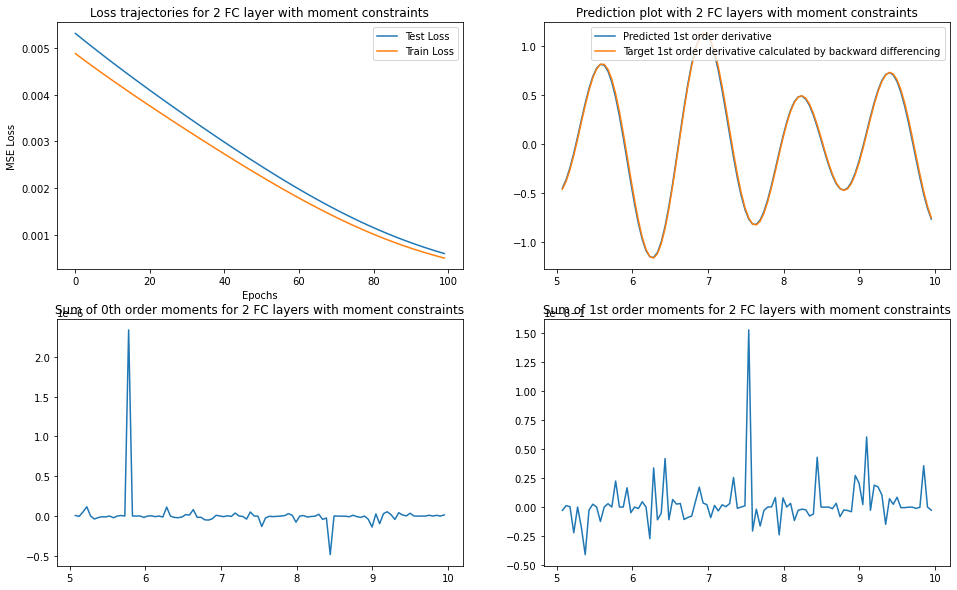

In [3]:
fig, ax = plt.subplots(2, 2)
fig.set_figwidth(16)
fig.set_figheight(10)

ax[0,0].plot(test_loss,label = "Test Loss")
ax[0,0].plot(train_loss,label = "Train Loss")
ax[0,0].legend(loc = "upper right")
ax[0,0].set_xlabel("Epochs")
ax[0,0].set_ylabel("MSE Loss")
ax[0,0].set_title("Loss trajectories for 2 FC layer with moment constraints")

pred = model(test_inputs)
pred = pred.cpu().detach().numpy()
test_inputs = test_inputs.to('cpu').detach().numpy()
test_outputs = test_outputs.to('cpu').detach().numpy()

ax[0,1].plot(x[-99:-1],(pred*test_inputs).sum(1),label = 'Predicted 1st order derivative')
ax[0,1].plot(x[-99:-1],test_outputs.flatten(),label = 'Target 1st order derivative calculated by backward differencing')
ax[0,1].legend()
ax[0,1].set_title("Prediction plot with 2 FC layers with moment constraints")

ax[1,0].plot(x[-99:-1],pred[:,0]+pred[:,1]+pred[:,2])
ax[1,0].set_yticks([-0.15,-0.1,-0.05,0,0.05,0.1,0.15])
ax[1,0].set_title("Sum of 0th order moments for 2 FC layers with moment constraints")

ax[1,1].plot(x[-99:-1],(del_x*pred[:,0])+(del_x*(-1)*pred[:,2]))
ax[1,1].set_yticks([-1.04,-1.02,-1,-0.98,-0.96,-0.94,-0.92])
ax[1,1].set_title("Sum of 1st order moments for 2 FC layers with moment constraints")

# Storing predicted coefficients in text file

In [12]:
file = open("Predicted_coefficients_test_set_with_Cvxpy.txt",'w')
for i in pred:
    file.write(str(i) + "\n")
file.close()